#  1. Business Understanding

Proteins are essential biomolecules composed of amino acid chains, ranging from 44 to 27,000 amino acids in length. While much is understood about proteins, ongoing research continues to unveil new ones. They play crucial roles in structural, regulatory, and enzymatic processes within the human body, and studying them has been pivotal in comprehending various bodily functions and degradation pathways. One significant challenge in elucidating a protein's function is its classification. Identifying the protein family to which a novel protein belongs aids in understanding evolutionary relationships and assessing its overall function. By leveraging amino acid sequence and residue data, the modeling process aims to classify proteins into their respective families, facilitating the unraveling of their functions. With potential application in various fields, including drug discovery, biotechnology, and personalized medicine.

### Importing Necessary Packages/Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import Bio
from Bio import SeqIO
import tensorflow as tf

# 2. Data Understanding

The data utilized in this project was downloaded from Kaggle and sourced from the Research Collaboratory for Structural Bioinformatics (RCSB) Protein Data Bank (PDB). The dataset included 2 dataframes with 141,401 and 467,304 entries, respectively. After extensive data manipulation 144,378 entries were left including target proteins. As mentioned above the input features were residue count and amino acid sequence. Files can be directly downloaded from the following link: https://www.kaggle.com/datasets/shahir/protein-data-set/code?datasetId=11797&sortBy=voteCount

- files names: pdb_data_no_dups & pdb_data_seq
- files can be acessed at same level as notebook

### Importing Data

In [2]:
# Importing data containing protein info
df1 = pd.read_csv('pdb_data_no_dups.csv')
df1.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [3]:
# Looking at shape of df1
df1.shape

(141401, 14)

In [4]:
#Importing data containing protein/sequence info
df2 = pd.read_csv('pdb_data_seq.csv')
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
# Looking at shape of df2
df2.shape

(467304, 5)

* Data Frames 1 & 2 have 3 common columns structureId, residueCount, & macromoleculeType

# 3. Data Preparation

Several steps were taken to adequately prepare the raw data for modeling. Both data frames were merged using an inner join and outer join. Ultimately, the inner joined dataframes were used for modeling because it represented a common cross section between both dataframes without generating additional rows containing null values. The remaining null values were also dropped in addition to any columns not pertinent for modeling. Finally, the data was subsetted to only contain proteins in the 'macromolecule_Type_x' column. 

#### Merging DataFrames

* Inner Join - Outputs datafame with intersection of both dataframes

In [6]:
# Inner Join(df1+df2)
inner_df = pd.merge(df1,df2, how='inner', on='structureId')
inner_df.head(10)

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG,24,DNA
6,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,B,CGCAAATTTGCG,24,DNA
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
9,103D,DNA,SOLUTION NMR,DNA,24,NaN,7502.93,NaN,NaN,NaN,NaN,NaN,NaN,1994.0,A,GTGGAATGGAAC,24,DNA


In [7]:
inner_df.shape

(471149, 18)

* Outer Join - Maintains integerity of both data sets fills in blank spaces with null values

In [8]:
# Outer Join(df1+df2)
outer_df = pd.merge(df1,df2, how='outer', on='structureId')
outer_df.head(10)

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20.0,DNA/RNA Hybrid
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20.0,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24.0,DNA
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24.0,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154.0,Protein
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG,24.0,DNA
6,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,B,CGCAAATTTGCG,24.0,DNA
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165.0,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154.0,Protein
9,103D,DNA,SOLUTION NMR,DNA,24,NaN,7502.93,NaN,NaN,NaN,NaN,NaN,NaN,1994.0,A,GTGGAATGGAAC,24.0,DNA


In [9]:
outer_df.shape

(471811, 18)

* Column "inner_df" will be used for further analysis

In [10]:
# Assigning new variable name for "inner_df"
protein_class_df = inner_df
protein_class_df.head()

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG,24,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


### Cleaning Data

* Removing Null Values

In [11]:
protein_class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471149 entries, 0 to 471148
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               471149 non-null  object 
 1   classification            471145 non-null  object 
 2   experimentalTechnique     471149 non-null  object 
 3   macromoleculeType_x       435379 non-null  object 
 4   residueCount_x            471149 non-null  int64  
 5   resolution                449486 non-null  float64
 6   structureMolecularWeight  471149 non-null  float64
 7   crystallizationMethod     314754 non-null  object 
 8   crystallizationTempK      317697 non-null  float64
 9   densityMatthews           389645 non-null  float64
 10  densityPercentSol         389768 non-null  float64
 11  pdbxDetails               385468 non-null  object 
 12  phValue                   340694 non-null  float64
 13  publicationYear           413513 non-null  f

* Irrelevant columns will be removed from dataframe
* The classification and sequence data are pertinent for further analysis. I will remove any missing or abherrant information from these 2 columns as well.

In [12]:
# Dropping publication year column(Column not relavant for assessing protein classificaion)
protein_class_df.drop('publicationYear', axis=1, inplace=True)
protein_class_df.head(10)

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,A,CGCGAATTCGCG,24,DNA
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,B,CGCGAATTCGCG,24,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,A,CGCAAATTTGCG,24,DNA
6,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,B,CGCAAATTTGCG,24,DNA
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
9,103D,DNA,SOLUTION NMR,DNA,24,NaN,7502.93,NaN,NaN,NaN,NaN,NaN,NaN,A,GTGGAATGGAAC,24,DNA


In [13]:
# Checking for nulls in "structureId" column
protein_class_df['structureId'].isnull().value_counts()

structureId
False    471149
Name: count, dtype: int64

* There are no null values in the "structureId" column

In [14]:
# Checking for nulls in "sequence" column
protein_class_df['sequence'].isnull().value_counts()

sequence
False    471121
True         28
Name: count, dtype: int64

* There are 28 null values in the "sequence" column that need to be removed from the dataframe in addition to the associated rows

In [15]:
protein_class_df.dropna(subset=['sequence'], inplace=True)

In [16]:
# Confirming that nulls were removed from "sequence" column
protein_class_df['sequence'].isnull().value_counts()

sequence
False    471121
Name: count, dtype: int64

In [17]:
# Confirming that the necessary columns were removed
protein_class_df['structureId'].isnull().value_counts()

structureId
False    471121
Name: count, dtype: int64

### Exploratory Data Analysis(EDA)

In [18]:
# checking object('string') type in 'sequence' columnb
protein_class_df['sequence'].dtype

dtype('O')

In [19]:
# Most Frequent macromoleule Types
protein_class_df['macromoleculeType_x'].value_counts()

macromoleculeType_x
Protein                       346322
Protein#RNA                    57898
Protein#DNA                    21343
DNA                             3794
Protein#DNA#RNA                 2712
RNA                             2410
Protein#RNA#DNA/RNA Hybrid       304
Protein#DNA#DNA/RNA Hybrid       159
DNA/RNA Hybrid                   141
DNA#RNA                          125
RNA#DNA/RNA Hybrid                74
Protein#DNA/RNA Hybrid            68
DNA#DNA/RNA Hybrid                26
Name: count, dtype: int64

In [20]:
# Subsetting dataframe so that protein is the only macromolecule type displayed in the dataframe
protein_classification = protein_class_df[protein_class_df.macromoleculeType_x == 'Protein']
protein_classification.shape

(346322, 17)

In [21]:
# Viewing final dataframe
protein_classification.head(20)

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,chainId,sequence,residueCount_y,macromoleculeType_y
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
15,104L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,332,2.80,37541.04,NaN,NaN,3.04,59.49,NaN,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,332,Protein
16,104L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,332,2.80,37541.04,NaN,NaN,3.04,59.49,NaN,NaN,B,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,332,Protein
17,104M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,153,1.71,18030.63,NaN,NaN,1.87,34.30,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 7.0",7.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,153,Protein
22,105M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,153,2.02,18030.63,NaN,NaN,1.83,33.00,"3.0 M AMMONIUM SULFATE, UNBUFFERED, pH 9.0",9.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,153,Protein
27,106M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.99,18181.84,NaN,NaN,3.05,59.70,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


* Duplicates are still present in the dataset
* Difference between duplicates are found in the "chainId" column

In [22]:
# looking at the protein type counts to determine the top 5 most frequent proteins in data set
protein_classification['classification'].value_counts()

classification
HYDROLASE                            46336
TRANSFERASE                          36424
OXIDOREDUCTASE                       34321
IMMUNE SYSTEM                        15615
LYASE                                11682
                                     ...  
STRUCTURAL PROTEIN, CELL CYCLE           1
KINASE (GLYCOGEN METABOLISM)             1
SURFACE GLYCOPROTEIN                     1
IMMUNE SYSTEM,HYDROLASE INHIBITOR        1
antimicrobial                            1
Name: count, Length: 4468, dtype: int64

In [23]:
# Unique proteins in 'classification' column
protein_classification['classification'].nunique()

4468

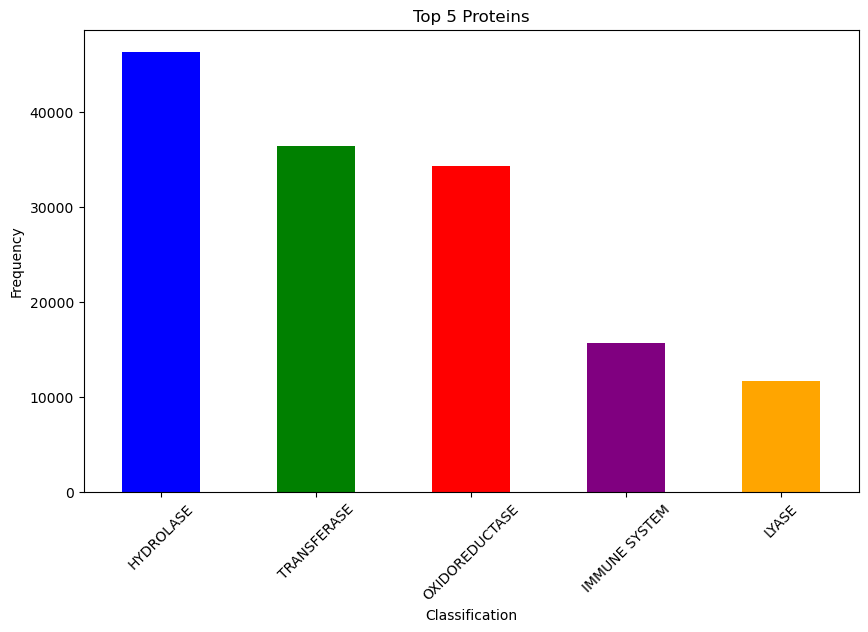

In [24]:
# Creating variable for top 5 proteins
top5_proteins = protein_classification['classification'].value_counts().head(5)

# Plotting the histogram
plt.figure(figsize=(10, 6))
top5_proteins.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Top 5 Proteins')
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.savefig('Images/top_5_proteins(1).png')
plt.show()

*  The 5 most frequent proteins were used as target features primarily to simplify the modeling process. There are 4,468 unique values for proteins in the 'classification' column which would increase the overall complexity of the modeling process. In addition to this there were a number of unique proteins with a value of one which would not be adequate for training due to a massive class imbalance between the top 5 occuring proteins and the single count proteins.

C:\Users\jedia\AppData\Local\Temp\ipykernel_12980\1300708135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_classification['sequence_length'] = sequence_lengths


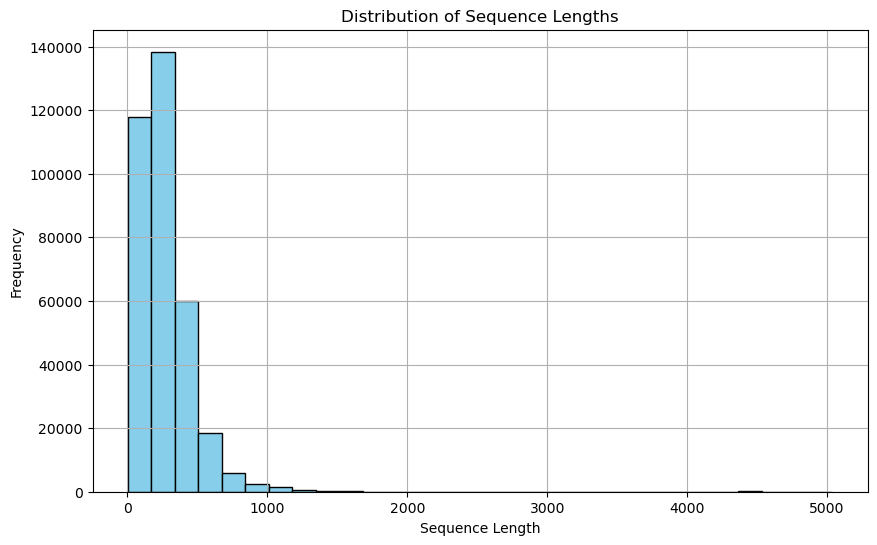

In [25]:
# Calculate the length of each sequence
sequence_lengths = protein_classification['sequence'].apply(len)
protein_classification['sequence_length'] = sequence_lengths

# Plotting the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(protein_classification['sequence_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('Images/Sequence_Length_Distribution(2).png')
plt.show()

* Most amino acid sequences are 500 and below in length. This gives an overall picture of the length and complexity of the amino acid sequences in the dataset and helps to assess how to incorporate these sequences in the modeling process. Amino acids can be handled as text and can be analyzed using classic NLP methods, such as bag-of-words, k-mers/n-grams and text search, as well as modern techniques such as word embedding, contextualized embedding, deep learning and neural language models. Approaches such as one hot encoding can be utilized as well, but based on the size of the amino acid sequence lengths in the above chart it could generate far too many columns and be difficult to deal with for analysis. The most practical option at the moment is Label Encoding which assigns a unique value to each sequence present in the data set.

In [26]:
experimental_tech = protein_classification['experimentalTechnique'].value_counts()
experimental_tech

experimentalTechnique
X-RAY DIFFRACTION                                            311210
ELECTRON MICROSCOPY                                           21641
SOLUTION NMR                                                  12356
SOLID-STATE NMR                                                 440
ELECTRON CRYSTALLOGRAPHY                                        147
SOLUTION SCATTERING                                              93
NEUTRON DIFFRACTION                                              85
SOLID-STATE NMR, ELECTRON MICROSCOPY                             78
NEUTRON DIFFRACTION, X-RAY DIFFRACTION                           50
X-RAY DIFFRACTION, NEUTRON DIFFRACTION                           39
POWDER DIFFRACTION                                               32
FIBER DIFFRACTION                                                28
ELECTRON MICROSCOPY, SOLUTION SCATTERING, SOLID-STATE NMR        24
ELECTRON MICROSCOPY, SOLID-STATE NMR                             16
SOLUTION SCATTERING, SOLUT

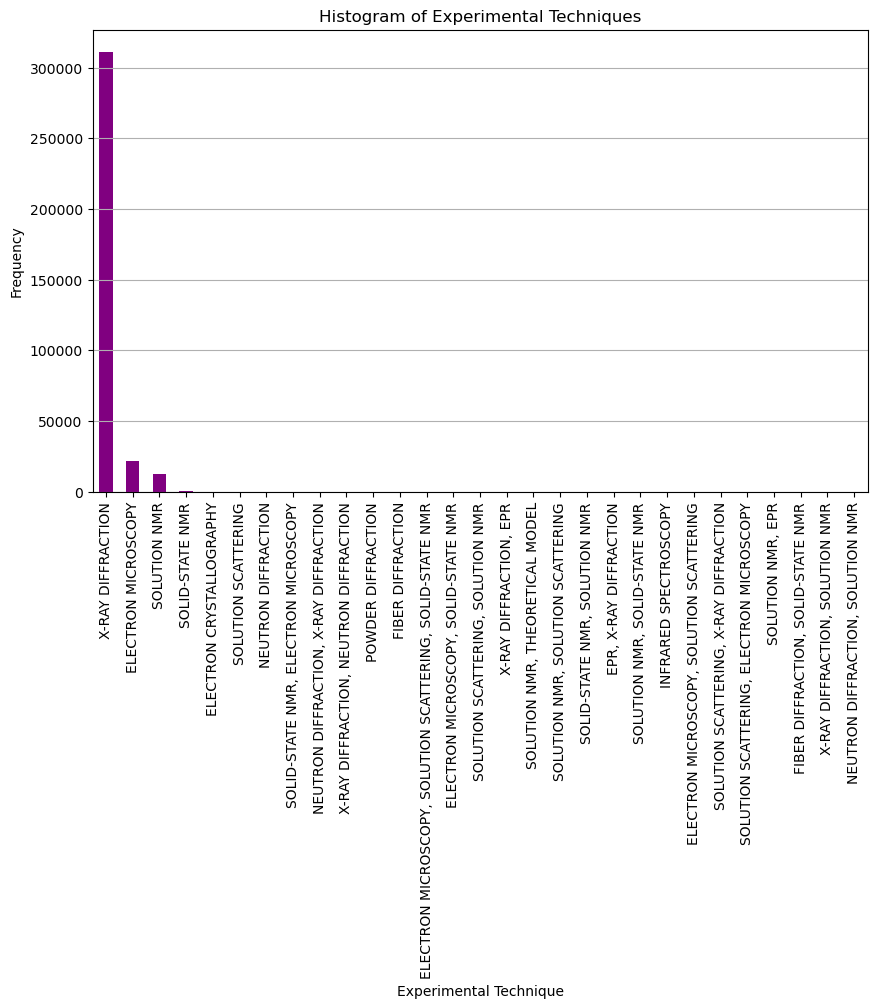

In [27]:
# Plot histogram
plt.figure(figsize=(10, 6))
experimental_tech.plot(kind='bar', color='purple')
plt.xlabel('Experimental Technique')
plt.ylabel('Frequency')
plt.title('Histogram of Experimental Techniques')
plt.grid(axis='y')
plt.savefig('Images/Experimental_Distribution(3).png')
plt.show()

In [28]:
# Looking at residue count(the amount of amino acids in a protein sequence)
residue_counts = protein_classification['residueCount_x'].value_counts() # Hist
residue_counts

residueCount_x
6614      2716
313236    1356
198       1251
271656    1176
306       1021
          ... 
1838         1
1931         1
3825         1
3450         1
2305         1
Name: count, Length: 3780, dtype: int64

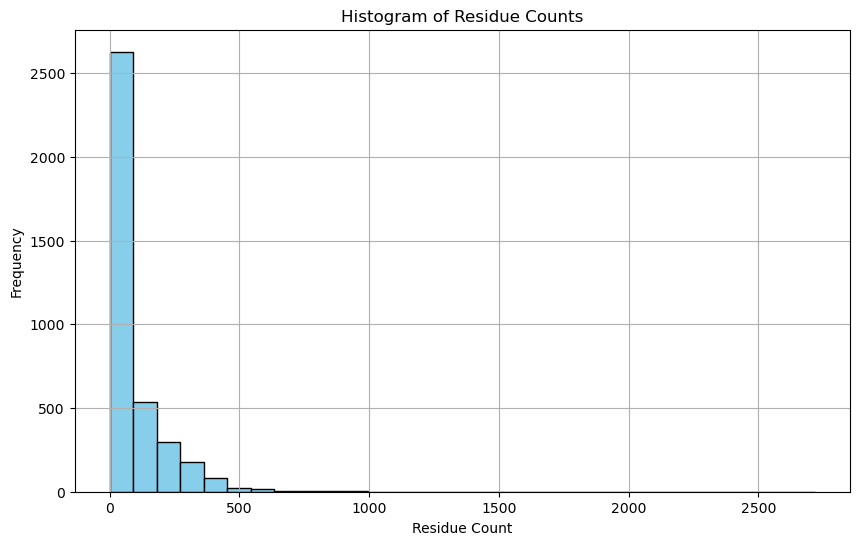

In [29]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(residue_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Residue Count')
plt.ylabel('Frequency')
plt.title('Histogram of Residue Counts')
plt.grid(True)
plt.savefig('Images/Residue_Distribution(4).png')
plt.show()

* This could poteintially be used for further subsetting using only the top 5 residue counts for further modelling  

In [30]:
# looking at value counts of another potential input feature(resolution indicates how distngushable atoms are from one another in a molecule)
resolution = protein_classification['resolution'].value_counts() #Hist
resolution

resolution
2.00     16691
2.50     12705
2.30     12638
1.90     12590
2.20     12146
         ...  
0.66         1
9.90         1
0.69         1
22.20        1
0.74         1
Name: count, Length: 596, dtype: int64

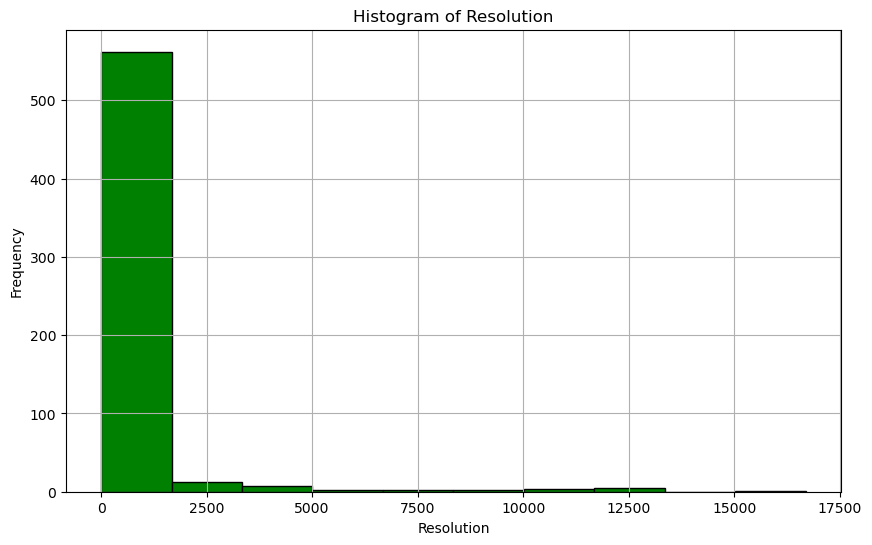

In [31]:
# Plot histogram with different colors
plt.figure(figsize=(10, 6))
plt.hist(resolution, bins=10, color=[ 'green'], edgecolor='black')
plt.xlabel('Resolution')
plt.ylabel('Frequency')
plt.title('Histogram of Resolution')
plt.grid(True)
plt.savefig('Images/Resolution_Distribution(5).png')
plt.show()

* This could potentially be used as an input feature

In [32]:
# Overall Molecular weight value counts
molecular_weight = protein_classification['structureMolecularWeight'].value_counts() # Hist
molecular_weight

structureMolecularWeight
34852576.00    1356
30226128.00    1176
18059512.00     862
36720.62        514
33813.86        365
               ... 
4030.67           1
35142.99          1
11713.88          1
43525.67          1
18112.80          1
Name: count, Length: 118620, dtype: int64

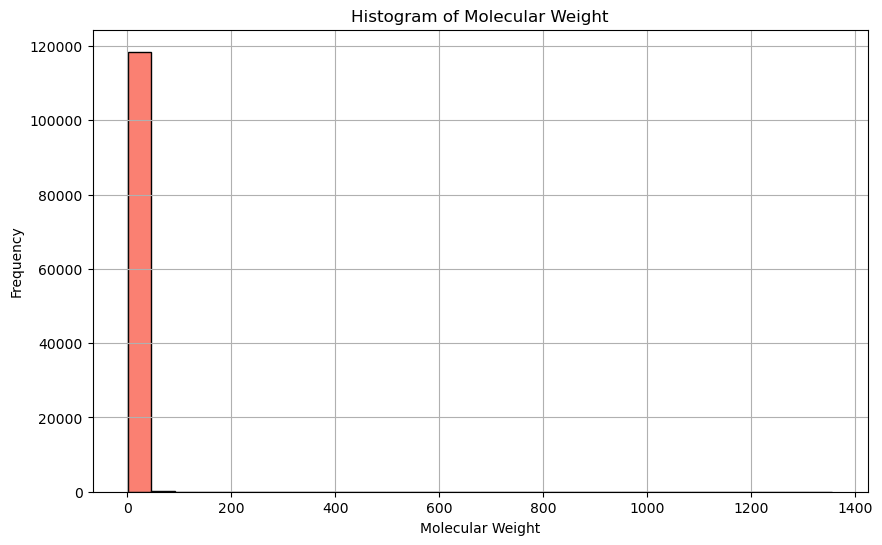

In [33]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(molecular_weight, bins=30, color='salmon', edgecolor='black')
plt.xlabel('Molecular Weight')
plt.ylabel('Frequency')
plt.title('Histogram of Molecular Weight')
plt.grid(True)
plt.savefig('Images/Molecular_Weight_Distribution(6).png')
plt.show()

* The above features 'experimentalTechnique', 'resolution', and 'structureMolecularWeight' can potentially be used as input features for protein classification independent of 'residueCount_x' ansd sequence. More analysis needs to be done on feature importance before constructing another model using the aforementioned input features. 

In [34]:
# Using The 5 most frequent proteins in 'classification' column 
# Get the top 5 most frequent proteins
top_proteins = protein_classification['classification'].value_counts().head(5).index.tolist()

# Subset the DataFrame to include only instances corresponding to the top 5 proteins
protein_classification_top5 = protein_classification[protein_classification['classification'].isin(top_proteins)]

# Confirm the subsetted DataFrame
print(protein_classification_top5['classification'].value_counts())

classification
HYDROLASE         46336
TRANSFERASE       36424
OXIDOREDUCTASE    34321
IMMUNE SYSTEM     15615
LYASE             11682
Name: count, dtype: int64


In [35]:
protein_classification_top5.shape

(144378, 18)

# 4. Modeling

* For the modeling process I decided to utilized KNN, Decision Tree, Random Forest, and Decision Tres as my classification  models.

### Dummy Model

In [36]:
# Dummy Model
# Convert categorical data to numerical data
encoder = LabelEncoder()
protein_classification_top5.loc[:,'sequence'] = encoder.fit_transform(protein_classification_top5['sequence'])

# Select only relevant features
X = protein_classification_top5[['sequence', 'residueCount_x']]
y = protein_classification_top5['classification']

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)

# Train the Dummy model
classifier = DummyClassifier()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_val)

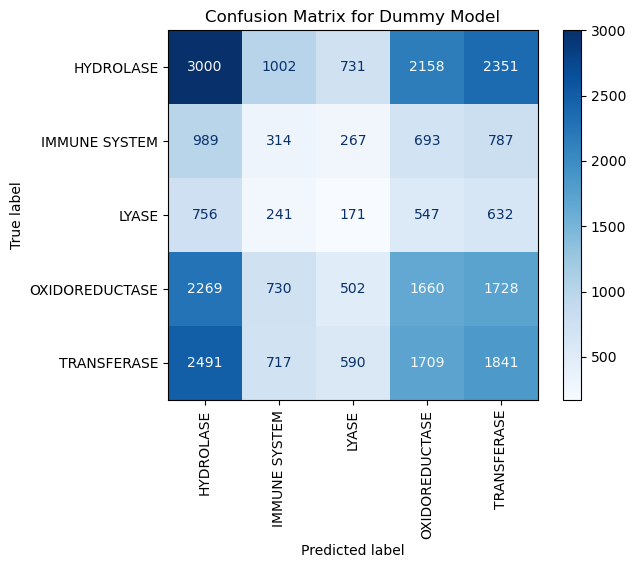

In [62]:
cm = confusion_matrix(y_val, y_pred)

# Create ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)

# Plot Confusion Matrix
disp.plot(cmap=plt.cm.Blues,  xticks_rotation='vertical')
plt.title('Confusion Matrix for Dummy Model')
plt.savefig('Images/Dummy_Confusion_Matrix(12).png')
plt.show()

In [37]:
classifier.score(X_val, y_val)

0.32005817980329687

### Initial Modeling 

In [38]:
# 1. KNN Model
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_val)

<Figure size 1000x800 with 0 Axes>

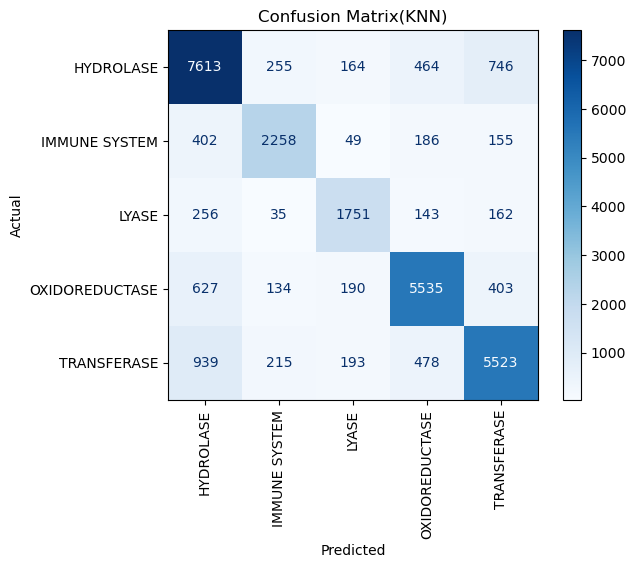

In [39]:
# Evaluating Model (confusion matrix)
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix(KNN)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/KNN_Confusion_Matrix(7).png')
plt.show()

In [40]:
# Evaluating Model (classification report)
print(classification_report(y_val, y_pred))

                precision    recall  f1-score   support

     HYDROLASE       0.77      0.82      0.80      9242
 IMMUNE SYSTEM       0.78      0.74      0.76      3050
         LYASE       0.75      0.75      0.75      2347
OXIDOREDUCTASE       0.81      0.80      0.81      6889
   TRANSFERASE       0.79      0.75      0.77      7348

      accuracy                           0.79     28876
     macro avg       0.78      0.77      0.78     28876
  weighted avg       0.79      0.79      0.79     28876



In [41]:
knn.score(X_train, y_train)

0.8683074365663889

In [42]:
# Model 2. Decision Tree
# Train the Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt.predict(X_val)

<Figure size 800x600 with 0 Axes>

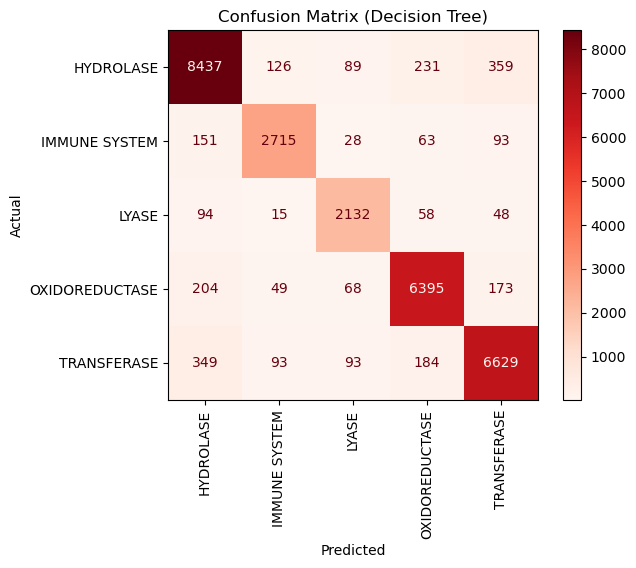

In [43]:
cm2 = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=np.unique(y_val))
disp.plot(cmap='Reds', xticks_rotation='vertical')
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/DT_Confusion_Matrix(8).png')
plt.show()

In [44]:
# Evaluating Model (classification report)
print(classification_report(y_val, y_pred))

                precision    recall  f1-score   support

     HYDROLASE       0.91      0.91      0.91      9242
 IMMUNE SYSTEM       0.91      0.89      0.90      3050
         LYASE       0.88      0.91      0.90      2347
OXIDOREDUCTASE       0.92      0.93      0.93      6889
   TRANSFERASE       0.91      0.90      0.90      7348

      accuracy                           0.91     28876
     macro avg       0.91      0.91      0.91     28876
  weighted avg       0.91      0.91      0.91     28876



In [45]:
dt.score(X_train, y_train)

0.9985223835799876

In [46]:
# Model 3. Random Forest
# Train the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_val)

<Figure size 800x600 with 0 Axes>

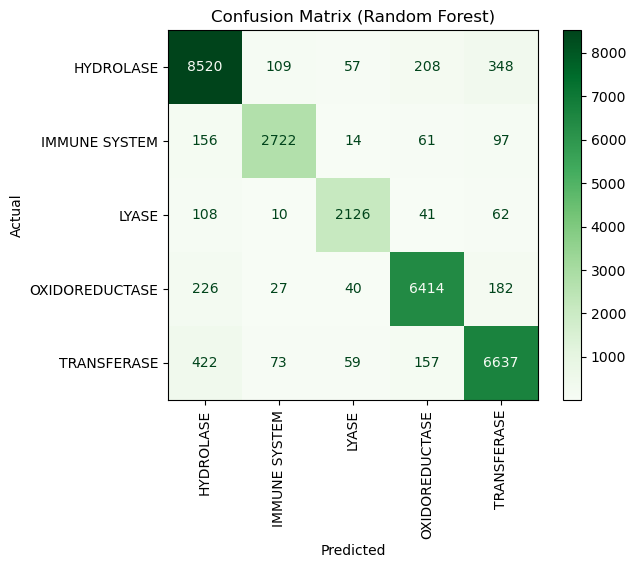

In [47]:
cm3 = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=np.unique(y_val))
disp.plot(cmap='Greens', xticks_rotation='vertical')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/RF_Confusion_Matrix(9).png')
plt.show()

In [48]:
# Evaluating Model (classification report)
print(classification_report(y_val, y_pred))

                precision    recall  f1-score   support

     HYDROLASE       0.90      0.92      0.91      9242
 IMMUNE SYSTEM       0.93      0.89      0.91      3050
         LYASE       0.93      0.91      0.92      2347
OXIDOREDUCTASE       0.93      0.93      0.93      6889
   TRANSFERASE       0.91      0.90      0.90      7348

      accuracy                           0.91     28876
     macro avg       0.92      0.91      0.91     28876
  weighted avg       0.92      0.91      0.91     28876



In [49]:
rf.score(X_train, y_train)

0.9985108397017062

In [50]:
# Model 4. Extra Trees
# Train the Extra Trees model
et = ExtraTreesClassifier()
et.fit(X_train, y_train)

# Make predictions on the test set
y_pred = et.predict(X_val)

<Figure size 800x600 with 0 Axes>

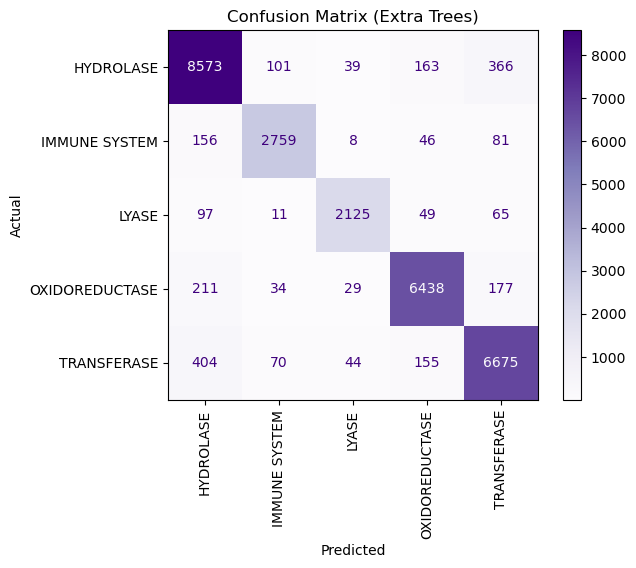

In [51]:
cm4 = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=np.unique(y_val))
disp.plot(cmap='Purples', xticks_rotation='vertical')
plt.title('Confusion Matrix (Extra Trees)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Images/ET_Confusion_Matrix(10).png')
plt.show()

In [52]:
# Evaluating Model (classification report)
print(classification_report(y_val, y_pred))

                precision    recall  f1-score   support

     HYDROLASE       0.91      0.93      0.92      9242
 IMMUNE SYSTEM       0.93      0.90      0.92      3050
         LYASE       0.95      0.91      0.93      2347
OXIDOREDUCTASE       0.94      0.93      0.94      6889
   TRANSFERASE       0.91      0.91      0.91      7348

      accuracy                           0.92     28876
     macro avg       0.93      0.92      0.92     28876
  weighted avg       0.92      0.92      0.92     28876



In [53]:
et.score(X_train, y_train)

0.9985223835799876

### Model Tuning

* The model with the best overall scores was the extra trees model
* This model is untuned and based on the testing score above we can see that the model is over fit
* Gridsearch will be used for further tuning to get a better fit

In [54]:
# Define the parameter grid you want to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Extra Trees classifier
extra_trees = ExtraTreesClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=extra_trees, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.9010805164156197


In [55]:
# Define the parameter grid you want to search
param_grid = {
    'n_estimators': [70, 100, 125],
    'max_depth': [ 10, 20, 40],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

# Initialize the Extra Trees classifier
extra_trees = ExtraTreesClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=extra_trees, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

Best Parameters: {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 125}
Best Score: 0.9006534006478599


In [56]:
# Define the parameter grid you want to search
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [40, 50, 60],
    'min_samples_split': [2, 3, 5,],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

# Initialize the Extra Trees classifier
extra_trees = ExtraTreesClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=extra_trees, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the validation set using the best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

Best Parameters: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.901138251131556


In [57]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Make predictions on the validation set using the best estimator
y_val_pred = best_estimator.predict(X_val)

# Evaluate the predictions against the true labels
validation_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.9205914946668514


<Figure size 800x600 with 0 Axes>

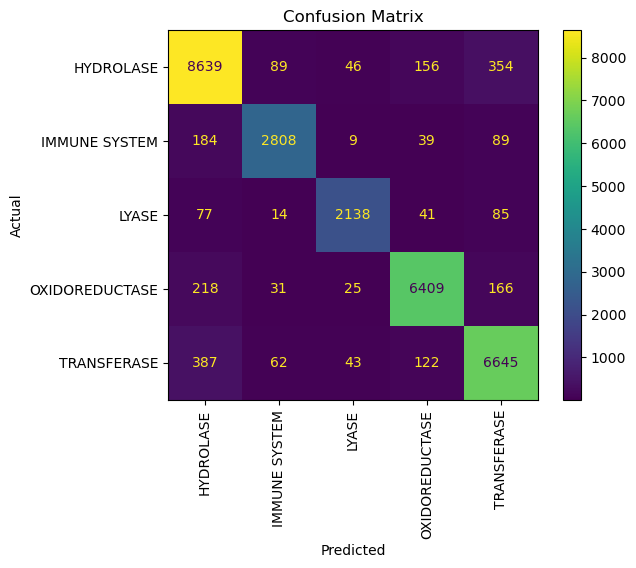

In [58]:
# Make predictions on test data
y_pred = best_estimator.predict(X_test)

# Generate confusion matrix
cmf = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cmf, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Images/Final_Confusion_Matrix(11).png')
plt.show()

In [60]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Make predictions on the validation set using the best estimator
y_val_pred = best_estimator.predict(X_test)

# Evaluate the predictions against the true labels
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9225308214434133


# 5. Evaluation 

The metric used for evalution was accuracy. This metric assesses the efficacy of my model by looking at the amount of data points that were predicted correctly. In the final confusion matrix after tuning my model and comparing the validation and test sets. The final accuracy between both was about 92%. Despite this high accuracy there were a fair amount of data points that were not predicted correctly. The incorrect predictions that stand out were the 358 predictions where hydrolase was incorrectly predicted as transferase as well as the 218 instances of hydrolase being predicted as oxidireductase. There were aslo 184 instances of Hydrolases being predicted ad Immunoglobulins, 354 instances of transferases predicted as hydrolases, 156 instances of oxioreductases predicted as hydrolases, 122 instance of oxioreductases predicted as transferases and finally 166 instances of transferases being predicted as oxioreductase. Despite the high amount of correct predictions I wouldn't feel comfortable deploying such a model in an industry setting. Science is a field highly dependent on precision and accuracy and if there is no other way to further weed out the incorrect predictions I would not feel comfotable using this model.  

# 6. Next Steps

1) Conduct comparative analysis between sequences to see if similarities between amino acid sequences could lead to incorrect predictions.

2) Use other input features to see if an effective prediction model can still be built without sequence or residue data.

3) Create and unsupervised neural net to analyze sequence data.